In [1]:
import numpy as np
import matplotlib.pyplot as plt

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch_model import EfficientNet

# microtorch imports
import sys
import os
sys.path.append(os.path.abspath(".."))
import microtorch as mt
import microtorch.nn.functional as F
from microtorch.optim import SGD
from verification.microtorch_model import InefficientNet

# prevent file paths from being printed
import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

In [3]:
micro_model = InefficientNet()
torch_model = EfficientNet()

# sync all parameters so that we have an identical starting point on the loss landscape
with torch.no_grad():
    torch_model.conv1.weight.data = torch.from_numpy(micro_model.conv1.w.data).clone()
    torch_model.conv1.bias.data = torch.from_numpy(micro_model.conv1.b.data.reshape(-1)).clone()
    
    torch_model.conv2.weight.data = torch.from_numpy(micro_model.conv2.w.data).clone()
    torch_model.conv2.bias.data = torch.from_numpy(micro_model.conv2.b.data.reshape(-1)).clone()
    
    torch_model.conv3.weight.data = torch.from_numpy(micro_model.conv3.w.data).clone()
    torch_model.conv3.bias.data = torch.from_numpy(micro_model.conv3.b.data.reshape(-1)).clone()
    
    torch_model.linear1.weight.data = torch.from_numpy(micro_model.linear1.w.data).clone()
    torch_model.linear1.bias.data = torch.from_numpy(micro_model.linear1.b.data).clone()
    
    torch_model.linear2.weight.data = torch.from_numpy(micro_model.linear2.w.data).clone()
    torch_model.linear2.bias.data = torch.from_numpy(micro_model.linear2.b.data).clone()

In [4]:
lr = 0.01
micro_optim = SGD(micro_model.parameters(), lr=lr)
torch_optim = optim.SGD(torch_model.parameters(), lr=lr)

In [5]:
micro_losses = []
torch_losses = []

# training for 1 full epoch
for step, (pt_inputs, pt_labels) in enumerate(trainloader):

    # dataprep for microtorch
    x_np = pt_inputs.numpy()
    y_onehot = np.zeros((len(pt_labels), 10), dtype=np.float32)
    y_onehot[np.arange(len(pt_labels)), pt_labels.numpy()] = 1.0
    mt_inputs = mt.Tensor(x_np)
    mt_targets = mt.Tensor(y_onehot)

    # microtorch step
    micro_optim.zero_grad()
    out_mt = micro_model(mt_inputs)
    loss_mt = F.cross_entropy(out_mt, mt_targets)
    loss_mt.backward()
    micro_optim.step()
    micro_losses.append(loss_mt.data)

    # pytorch step
    torch_optim.zero_grad()
    out_pt = torch_model(pt_inputs)
    loss_pt = nn.functional.cross_entropy(out_pt, pt_labels)
    loss_pt.backward()
    torch_optim.step()
    torch_losses.append(loss_pt.item())

    if step % 10 == 0:
        diff = abs(loss_mt.data - loss_pt.item())
        print(f"Batch {step}/{len(trainloader)}: MT={loss_mt.data:.5f} | PT={loss_pt.item():.5f} | Diff={diff:.5f}")

Batch 0/235: MT=2.33525 | PT=2.33525 | Diff=0.00000
Batch 10/235: MT=2.22065 | PT=2.22065 | Diff=0.00000
Batch 20/235: MT=2.09655 | PT=2.09655 | Diff=0.00000
Batch 30/235: MT=1.96705 | PT=1.96705 | Diff=0.00000
Batch 40/235: MT=1.80409 | PT=1.80409 | Diff=0.00000
Batch 50/235: MT=1.56789 | PT=1.56789 | Diff=0.00000
Batch 60/235: MT=1.45903 | PT=1.45903 | Diff=0.00000
Batch 70/235: MT=1.24498 | PT=1.24498 | Diff=0.00000
Batch 80/235: MT=1.02452 | PT=1.02452 | Diff=0.00000
Batch 90/235: MT=0.88144 | PT=0.88144 | Diff=0.00000
Batch 100/235: MT=0.74398 | PT=0.74398 | Diff=0.00000
Batch 110/235: MT=0.78301 | PT=0.78301 | Diff=0.00000
Batch 120/235: MT=0.68699 | PT=0.68699 | Diff=0.00000
Batch 130/235: MT=0.61904 | PT=0.61904 | Diff=0.00000
Batch 140/235: MT=0.48476 | PT=0.48476 | Diff=0.00000
Batch 150/235: MT=0.64421 | PT=0.64421 | Diff=0.00000
Batch 160/235: MT=0.50850 | PT=0.50850 | Diff=0.00000
Batch 170/235: MT=0.49752 | PT=0.49752 | Diff=0.00000
Batch 180/235: MT=0.51400 | PT=0.51400 

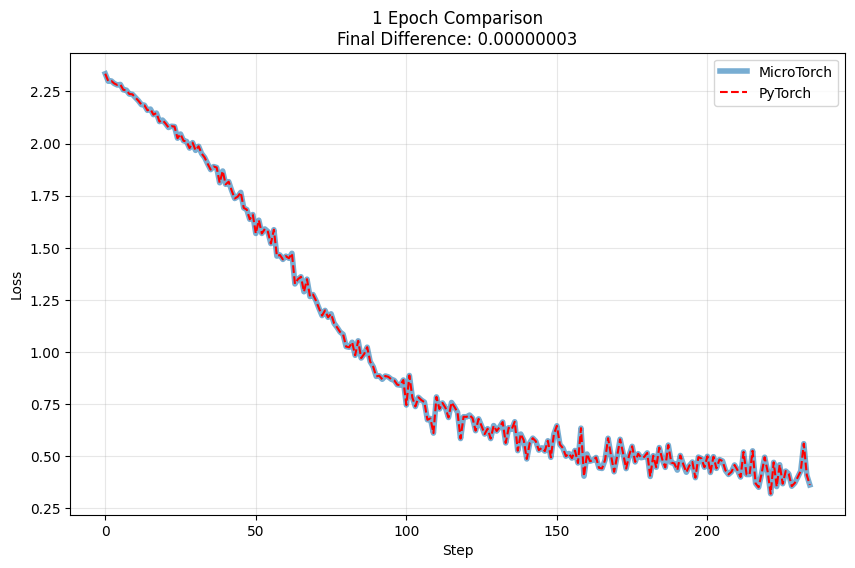

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(micro_losses, label="MicroTorch", linewidth=4, alpha=0.6)
plt.plot(torch_losses, label="PyTorch", linestyle="--", color='red')
plt.title(f"1 Epoch Comparison\nFinal Difference: {abs(micro_losses[-1] - torch_losses[-1]):.8f}")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

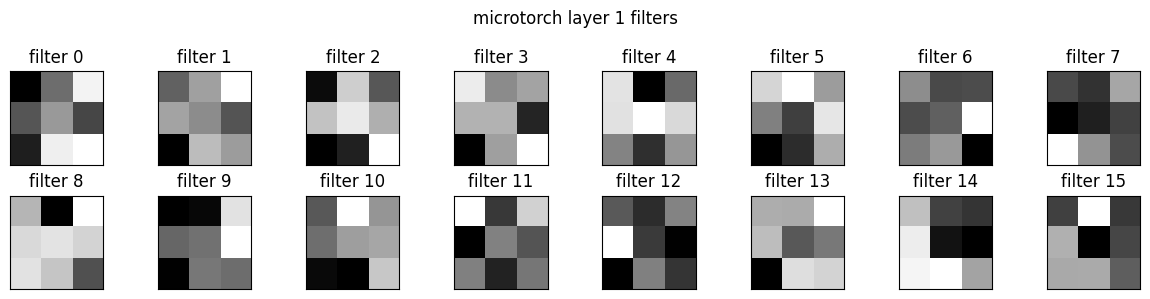

In [7]:
def visualize_filters(model):
    weights = model.conv1.w.data
    w_min, w_max = weights.min(), weights.max()
    weights = (weights - w_min) / (w_max - w_min)
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    fig.suptitle("microtorch layer 1 filters")
    
    for i, ax in enumerate(axes.flat):
        if i < len(weights):
            ax.imshow(weights[i, 0, :, :], cmap='gray', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"filter {i}")
            
    plt.tight_layout()
    plt.show()

visualize_filters(micro_model)